# HYPE Whale Tracker - Staking Balances & Unstaking Queue

Track staking balances and unstaking status for 16 whale wallets.

In [170]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import time
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns

# API Configuration
BASE_URL = "https://api.hypurrscan.io"
RATE_LIMIT_DELAY = 0.1  # 100ms between requests

# Set up plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## Wallet Addresses

In [171]:
# All whale wallet addresses
wallets = [
    "0x39a3bbe71987f32e115dc807c1138b9a84f32795",
    "0x6ef1eda0e85281b0c69ca49b1e3876e99a513ad9",
    "0x120ebd61a6cda38818d4c3a25e7d83dcb6912d5d",
    "0x9abe126127818c6440db88cf32a222e47193e0b0",
    "0x1f68cb6b0385844178dd3865e7dc6320c2a88053",
    "0x0ed92cffa284388ef38f97f56e6b2ceb6e9c14f8",
    "0xcd1a5fb7c3a5ad2a13fce54853b3c3a01396e525",
    "0x718d8fd9e566b802399ceafb19741c57d4244e8a",
    "0x0cda7d72834bb6662ffa77cf8adf99eaea239302",
    "0x407ed5d253a595ea8a4d8b2e2f8e9d079f51ca93",
    "0x05dc811ddcd793cc5204ba3fc4ae665768938657",
    "0x6b40d2fc89c9672efd71b5b6b11bcd5f3673afe7",
    "0xb1c3f6f0c1aefb25ec825ac8e0ba517a976285e3",
    "0x81501f4da49c18bb3f69e4abfeb4d2346ac5fce8",
    "0x5cef1ba44d97bae8296288d41206fdf6951a2ab8",
    "0x70e1929eec76555e99dbc75cbad1c2ac7e7e7bf6",
]

print(f"Tracking {len(wallets)} wallets")

Tracking 16 wallets


## Helper Functions

In [172]:
def get_holders_data(token="HYPE"):
    """Fetch holder data for a token"""
    try:
        response = requests.get(f"{BASE_URL}/holders/{token}")
        response.raise_for_status()
        time.sleep(RATE_LIMIT_DELAY)
        return response.json()
    except Exception as e:
        print(f"Error fetching holders: {e}")
        return None

def get_unstaking_queue():
    """Fetch the full unstaking queue"""
    try:
        response = requests.get(f"{BASE_URL}/fullUnstakingQueue")
        response.raise_for_status()
        time.sleep(RATE_LIMIT_DELAY)
        return response.json()
    except Exception as e:
        print(f"Error fetching unstaking queue: {e}")
        return None

def format_hype_amount(amount):
    """Format HYPE amount with proper decimals (18 decimals)"""
    if amount is None:
        return 0
    return float(amount) / 1e8

## Fetch Staking Balances

In [173]:
print("Fetching HYPE and staked HYPE data...\n")

# Get regular HYPE holders
hype_holders = get_holders_data("HYPE")
# Get staked HYPE holders
staked_holders = get_holders_data("stakedHYPE")

# Build data for our wallets
wallet_balances = []

if hype_holders and 'holders' in hype_holders and staked_holders and 'holders' in staked_holders:
    hype_dict = hype_holders['holders']
    staked_dict = staked_holders['holders']
    
    for address in wallets:
        hype_balance_raw = hype_dict.get(address, 0)
        staked_balance_raw = staked_dict.get(address, 0)
        
        # Handle if values are already formatted (float) or need formatting (int/string)
        if isinstance(hype_balance_raw, (int, str)):
            hype_balance = format_hype_amount(hype_balance_raw)
        else:
            hype_balance = float(hype_balance_raw)
            
        if isinstance(staked_balance_raw, (int, str)):
            staked_balance = format_hype_amount(staked_balance_raw)
        else:
            staked_balance = float(staked_balance_raw)
        
        wallet_balances.append({
            'Address': f"{address[:6]}...{address[-4:]}",
            'Full Address': address,
            'HYPE Balance': hype_balance,
            'Staked HYPE': staked_balance,
            'HYPE (formatted)': f"{hype_balance:,.2f}",
            'Staked HYPE (formatted)': f"{staked_balance:,.2f}",
            'Unstaking Locked': 0,
            'Unstaking Unlocked': 0,
            'Unstaking Locked (formatted)': "0.00",
            'Unstaking Unlocked (formatted)': "0.00",
            'Unstaking Count': 0,
            'Next Unlock': "-",
            'Days Until Unlock': None
        })
    
    print(f"✓ Fetched data for {len(wallet_balances)} wallets")
else:
    print("ERROR: Could not fetch HYPE or staking data")
    print(f"HYPE data present: {hype_holders is not None and 'holders' in hype_holders if hype_holders else False}")
    print(f"Staked data present: {staked_holders is not None and 'holders' in staked_holders if staked_holders else False}")
    wallet_balances = []

Fetching HYPE and staked HYPE data...

✓ Fetched data for 16 wallets


## Check Unstaking Queue

In [174]:
print("\nFetching unstaking queue...\n")

unstaking_queue = get_unstaking_queue()

if unstaking_queue:
    # Create set of wallet addresses (lowercase for comparison)
    whale_addresses = {addr.lower() for addr in wallets}
    
    # Filter for our whale wallets using the 'user' field
    whale_unstaking = [x for x in unstaking_queue if x.get("user", "").lower() in whale_addresses]
    
    print(f"Found {len(whale_unstaking)} unstaking entries for tracked wallets\n")
    
    # Get current time for comparison
    now = datetime.now()
    
    # Add unstaking info to wallet data
    for wallet in wallet_balances:
        addr = wallet['Full Address'].lower()
        unstaking_entries = [x for x in whale_unstaking if x.get("user", "").lower() == addr]
        
        if unstaking_entries:
            locked_amount = 0
            unlocked_amount = 0
            earliest_locked_time = None
            
            # Separate locked vs unlocked
            for entry in unstaking_entries:
                amount = format_hype_amount(entry.get('wei', 0))
                unlock_time = entry.get('time', 0)
                
                if unlock_time:
                    unlock_dt = datetime.fromtimestamp(unlock_time / 1000)
                    
                    if unlock_dt <= now:
                        # Already unlocked (ready to claim)
                        unlocked_amount += amount
                    else:
                        # Still locked (within 7-day period)
                        locked_amount += amount
                        if earliest_locked_time is None or unlock_dt < earliest_locked_time:
                            earliest_locked_time = unlock_dt
                else:
                    # If no time, assume locked
                    locked_amount += amount
            
            wallet['Unstaking Locked'] = locked_amount
            wallet['Unstaking Unlocked'] = unlocked_amount
            wallet['Unstaking Locked (formatted)'] = f"{locked_amount:,.2f}"
            wallet['Unstaking Unlocked (formatted)'] = f"{unlocked_amount:,.2f}"
            wallet['Unstaking Count'] = len(unstaking_entries)
            
            # Set next unlock time (earliest locked entry)
            if earliest_locked_time:
                wallet['Next Unlock'] = earliest_locked_time.strftime('%Y-%m-%d %H:%M')
                time_remaining = earliest_locked_time - now
                wallet['Days Until Unlock'] = max(0, time_remaining.days + (1 if time_remaining.seconds > 0 else 0))
            else:
                wallet['Next Unlock'] = "All Unlocked"
                wallet['Days Until Unlock'] = 0
        else:
            wallet['Unstaking Locked'] = 0
            wallet['Unstaking Unlocked'] = 0
            wallet['Unstaking Locked (formatted)'] = "0.00"
            wallet['Unstaking Unlocked (formatted)'] = "0.00"
            wallet['Unstaking Count'] = 0
            wallet['Next Unlock'] = "-"
            wallet['Days Until Unlock'] = None
    
    print("✓ Unstaking queue checked")
else:
    print("Could not fetch unstaking queue")
    for wallet in wallet_balances:
        wallet['Unstaking Locked'] = 0
        wallet['Unstaking Unlocked'] = 0
        wallet['Unstaking Locked (formatted)'] = "N/A"
        wallet['Unstaking Unlocked (formatted)'] = "N/A"
        wallet['Unstaking Count'] = 0
        wallet['Next Unlock'] = "N/A"
        wallet['Days Until Unlock'] = None


Fetching unstaking queue...

Found 11 unstaking entries for tracked wallets

✓ Unstaking queue checked


## Display Summary Table

In [ ]:
# Create DataFrame
df = pd.DataFrame(wallet_balances)

# Debug: print available columns
print("Available columns:", df.columns.tolist())
print()

# Check if dataframe is empty
if df.empty:
    print("ERROR: No wallet data found. Please run cell 7 to fetch balances first.")
else:
    # Add total column
    df['Total HYPE'] = df['HYPE Balance'] + df['Staked HYPE'] + df['Unstaking Locked'] + df['Unstaking Unlocked']
    df['Total HYPE (formatted)'] = df['Total HYPE'].apply(lambda x: f"{x:,.2f}")
    
    # Add staking status
    df['In Unstaking Queue'] = df['Unstaking Count'].apply(lambda x: 'Yes' if x > 0 else 'No')
    
    # Create sorting column for days (handle None values by putting them at end)
    df['Sort Days'] = df['Days Until Unlock'].apply(lambda x: 999 if x is None else x)
    
    # Sort by: 1) Days until unlock (earliest first), 2) Staked HYPE (descending)
    df_sorted = df.sort_values(['Sort Days', 'Staked HYPE'], ascending=[True, False])
    
    # Display table
    display_df = df_sorted[[
        'Address', 
        'HYPE (formatted)', 
        'Staked HYPE (formatted)', 
        'Unstaking Locked (formatted)',
        'Unstaking Unlocked (formatted)',
        'In Unstaking Queue',
        'Days Until Unlock',
        'Next Unlock'
    ]].copy()
    
    display_df.columns = [
        'Address', 
        'Liquid HYPE', 
        'Staked HYPE', 
        'Unstaking (Locked)',
        'Unlocked (Claimable)',
        'In Queue',
        'Days Left',
        'Next Unlock'
    ]
    
    # Replace None with "-" for display
    display_df['Days Left'] = display_df['Days Left'].apply(lambda x: f"{x}d" if x is not None else "-")
    
    print("\n" + "=" * 120)
    print("WHALE WALLET SUMMARY - HYPE HOLDINGS & STAKING STATUS")
    print("=" * 120)
    print()
    
    display(display_df)
    
    # Calculate totals (using original df, not sorted)
    total_hype = df['HYPE Balance'].sum()
    total_staked = df['Staked HYPE'].sum()
    total_locked = df['Unstaking Locked'].sum()
    total_unlocked = df['Unstaking Unlocked'].sum()
    grand_total = total_hype + total_staked + total_locked + total_unlocked
    
    print("\n" + "-" * 120)
    print(f"Total Liquid HYPE:           {total_hype:>15,.2f}")
    print(f"Total Staked HYPE:           {total_staked:>15,.2f}")
    print(f"Total Unstaking (Locked):    {total_locked:>15,.2f}  <- Still in 7-day unlock period")
    print(f"Total Unlocked (Claimable):  {total_unlocked:>15,.2f}  <- Ready to claim!")
    print(f"{'':32}{'-' * 20}")
    print(f"Grand Total:                 {grand_total:>15,.2f}")
    print("-" * 120)
    
    # Show percentages
    liquid_pct = (total_hype / grand_total * 100) if grand_total > 0 else 0
    staking_pct = (total_staked / grand_total * 100) if grand_total > 0 else 0
    locked_pct = (total_locked / grand_total * 100) if grand_total > 0 else 0
    unlocked_pct = (total_unlocked / grand_total * 100) if grand_total > 0 else 0
    
    print(f"\nLiquid: {liquid_pct:.1f}% | Staked: {staking_pct:.1f}% | Unstaking-Locked: {locked_pct:.1f}% | Unlocked-Claimable: {unlocked_pct:.1f}%")
    print(f"\nWallets in unstaking queue: {df['Unstaking Count'].astype(bool).sum()} / {len(df)}")
    print(f"Last updated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Available columns: ['Address', 'Full Address', 'HYPE Balance', 'Staked HYPE', 'HYPE (formatted)', 'Staked HYPE (formatted)', 'Unstaking Locked', 'Unstaking Unlocked', 'Unstaking Locked (formatted)', 'Unstaking Unlocked (formatted)', 'Unstaking Count', 'Next Unlock', 'Days Until Unlock']


WHALE WALLET SUMMARY - HYPE HOLDINGS & STAKING STATUS



,Address,Liquid HYPE,Staked HYPE,Unstaking (Locked),Unlocked (Claimable),In Queue,Days Left,Next Unlock
3,0x9abe...e0b0,0.01,0.00,0.00,"442,416.93",Yes,0.0d,All Unlocked
5,0x0ed9...14f8,"107,722.50",0.00,0.00,"238,948.00",Yes,0.0d,All Unlocked
0,0x39a3...2795,0.01,0.00,0.00,"262,345.72",Yes,0.0d,All Unlocked
4,0x1f68...8053,0.01,0.00,0.00,"239,260.98",Yes,0.0d,All Unlocked
2,0x120e...2d5d,0.00,0.00,0.00,"202,808.02",Yes,0.0d,All Unlocked
1,0x6ef1...3ad9,0.01,0.00,0.00,"166,734.99",Yes,0.0d,All Unlocked
6,0xcd1a...e525,0.00,"549,017.30",0.00,0.00,No,nand,-
8,0x0cda...9302,0.00,"302,743.07",0.00,0.00,No,nand,-
9,0x407e...ca93,0.00,"278,446.64",0.00,0.00,No,nand,-
13,0x8150...fce8,0.00,"228,094.34",0.00,0.00,No,nand,-



------------------------------------------------------------------------------------------------------------------------
Total Liquid HYPE:                107,722.54
Total Staked HYPE:              1,562,026.65
Total Unstaking (Locked):       1,270,555.79  <- Still in 7-day unlock period
Total Unlocked (Claimable):     1,552,514.64  <- Ready to claim!
                                --------------------
Grand Total:                    4,492,819.62
------------------------------------------------------------------------------------------------------------------------

Liquid: 2.4% | Staked: 34.8% | Unstaking-Locked: 28.3% | Unlocked-Claimable: 34.6%

Wallets in unstaking queue: 11 / 16
Last updated: 2026-01-13 10:43:45


## Visualizations

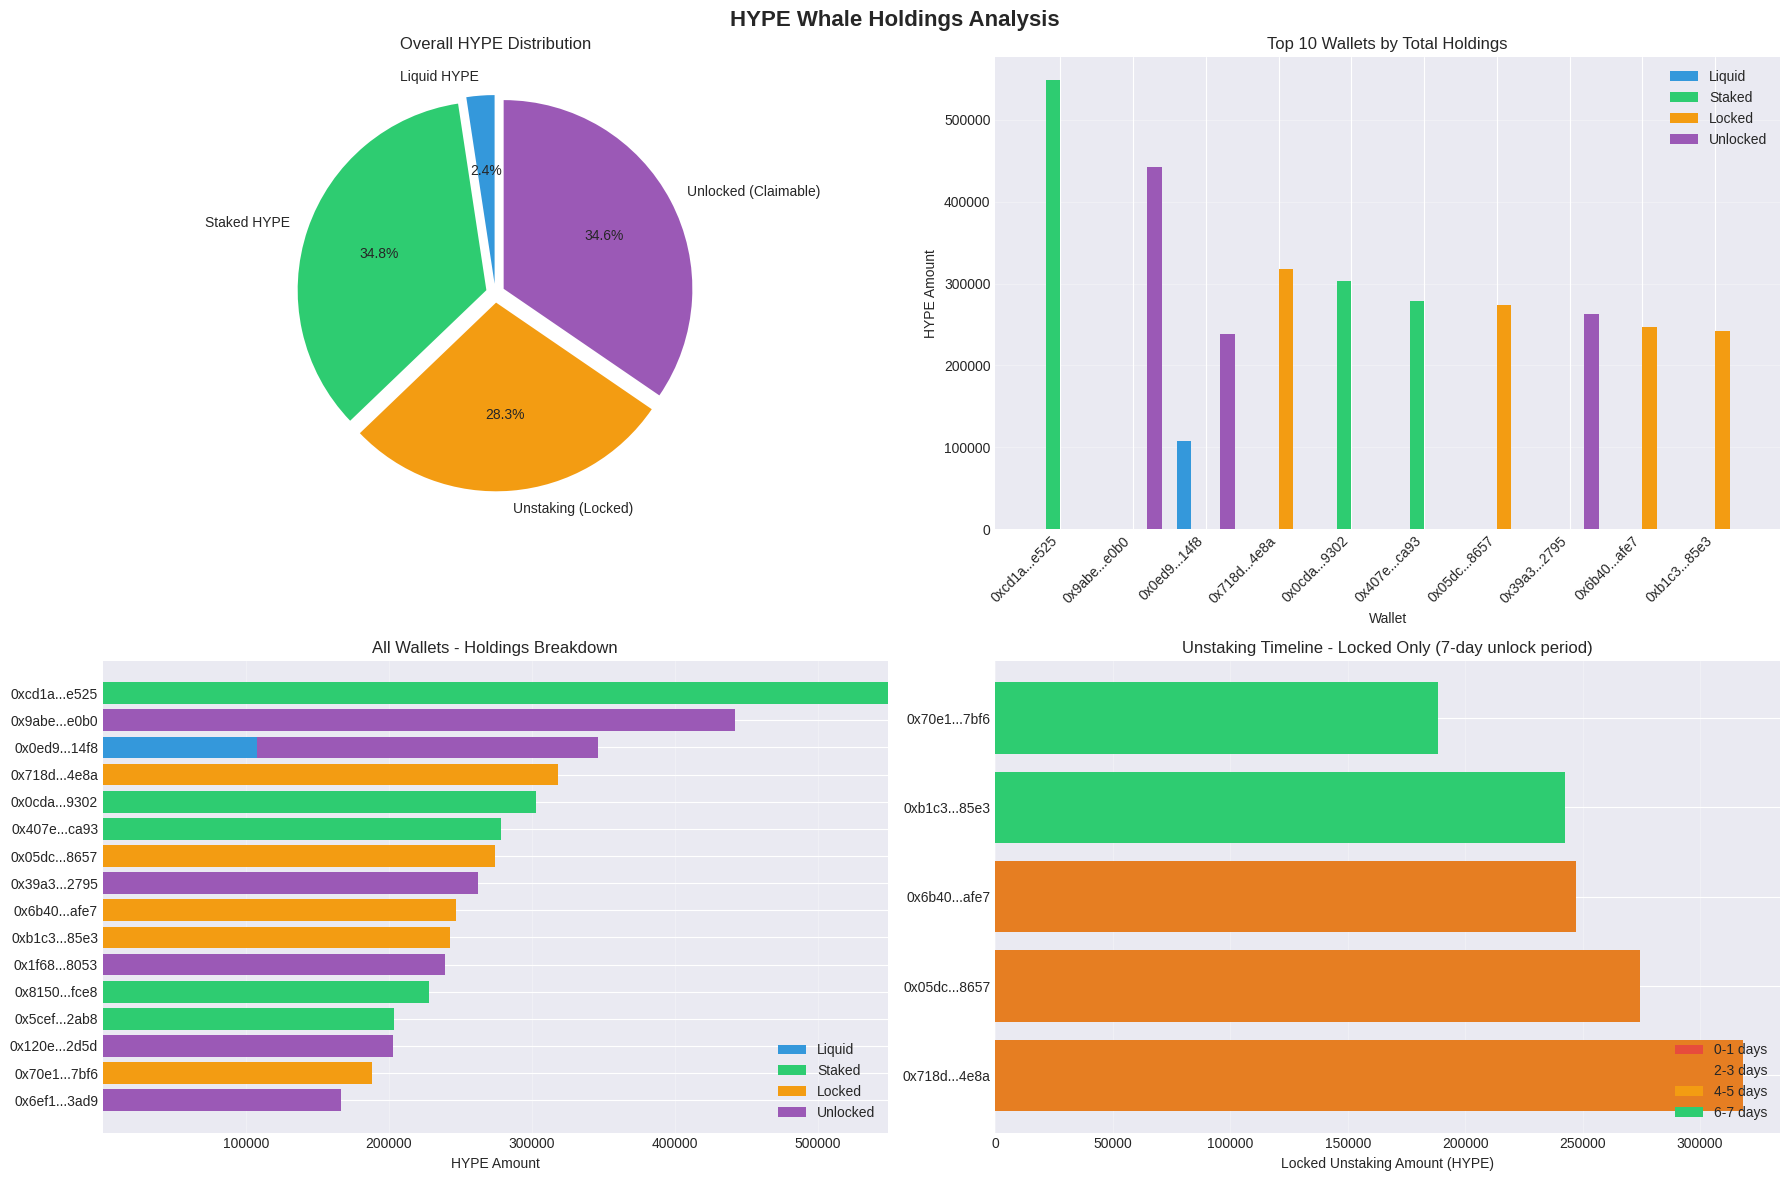

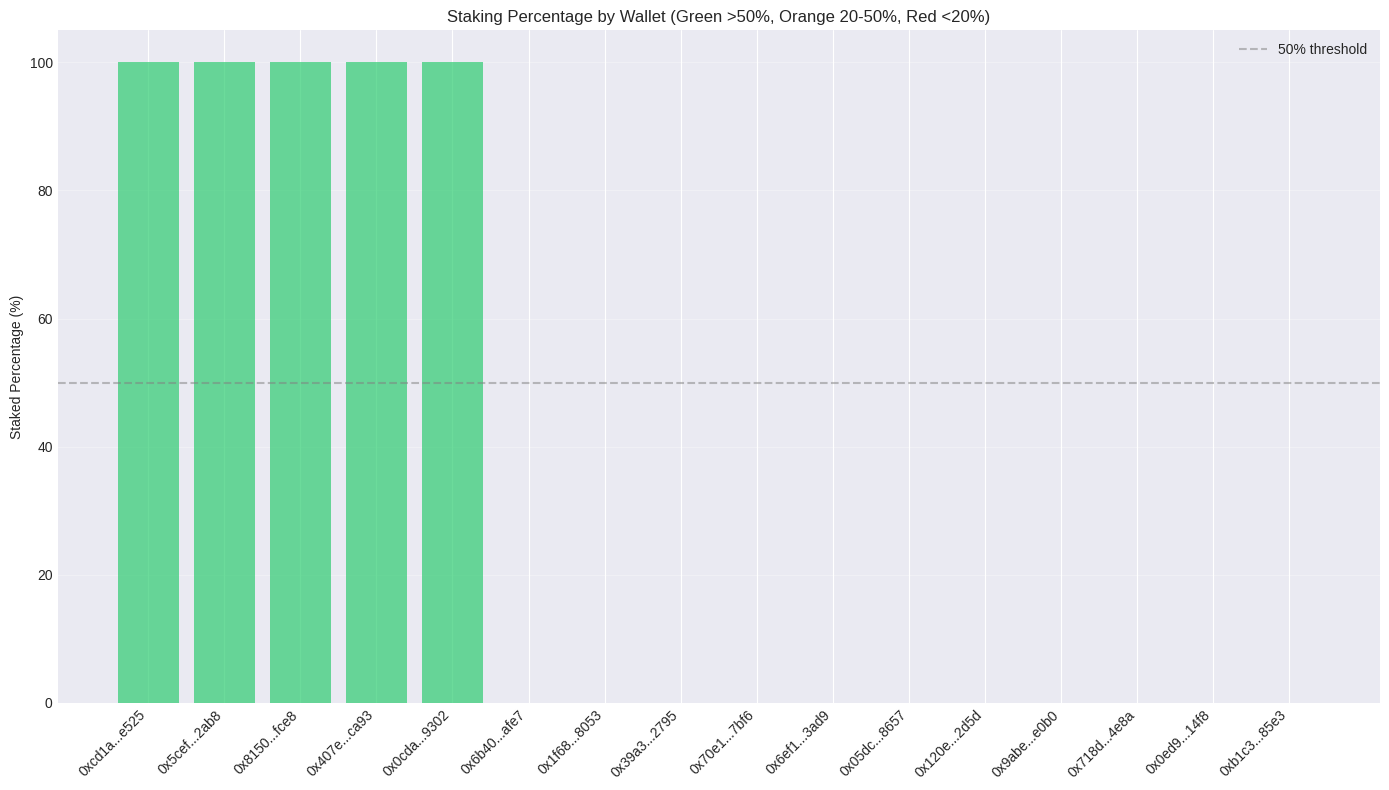

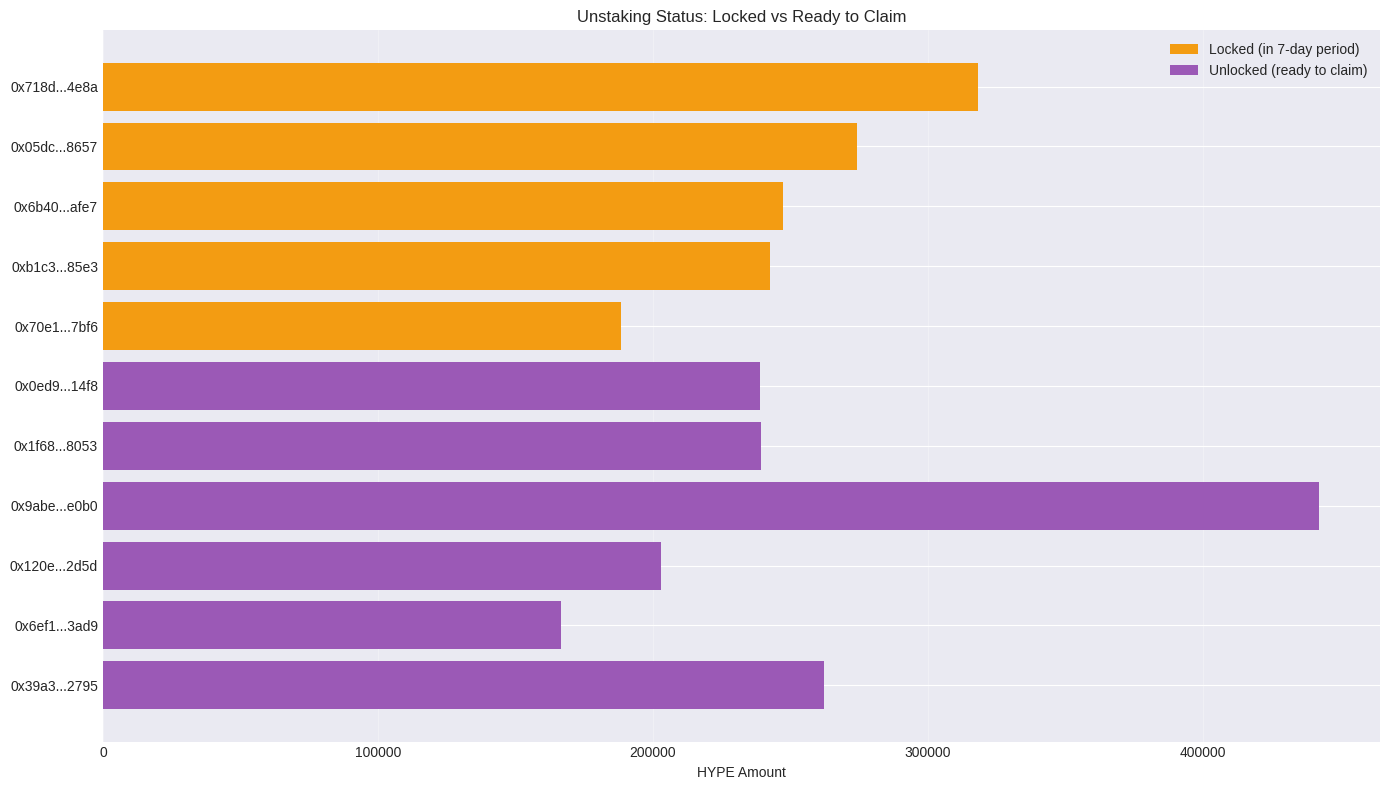

In [176]:
if not df.empty:
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle('HYPE Whale Holdings Analysis', fontsize=16, fontweight='bold')
    
    # 1. Overall Distribution Pie Chart
    ax1 = axes[0, 0]
    total_hype = df['HYPE Balance'].sum()
    total_staked = df['Staked HYPE'].sum()
    total_locked = df['Unstaking Locked'].sum()
    total_unlocked = df['Unstaking Unlocked'].sum()
    
    sizes = [total_hype, total_staked, total_locked, total_unlocked]
    labels = ['Liquid HYPE', 'Staked HYPE', 'Unstaking (Locked)', 'Unlocked (Claimable)']
    colors = ['#3498db', '#2ecc71', '#f39c12', '#9b59b6']
    explode = (0.05, 0.05, 0.05, 0.05)
    
    # Only show non-zero values
    filtered_data = [(s, l, c) for s, l, c in zip(sizes, labels, colors) if s > 0]
    if filtered_data:
        sizes, labels, colors = zip(*filtered_data)
        ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, explode=explode[:len(sizes)])
    ax1.set_title('Overall HYPE Distribution')
    
    # 2. Top 10 Wallets by Total Holdings
    ax2 = axes[0, 1]
    top_wallets = df.nlargest(10, 'Total HYPE')
    x = range(len(top_wallets))
    width = 0.2
    
    ax2.bar([i - 1.5*width for i in x], top_wallets['HYPE Balance'], width, label='Liquid', color='#3498db')
    ax2.bar([i - 0.5*width for i in x], top_wallets['Staked HYPE'], width, label='Staked', color='#2ecc71')
    ax2.bar([i + 0.5*width for i in x], top_wallets['Unstaking Locked'], width, label='Locked', color='#f39c12')
    ax2.bar([i + 1.5*width for i in x], top_wallets['Unstaking Unlocked'], width, label='Unlocked', color='#9b59b6')
    
    ax2.set_xlabel('Wallet')
    ax2.set_ylabel('HYPE Amount')
    ax2.set_title('Top 10 Wallets by Total Holdings')
    ax2.set_xticks(x)
    ax2.set_xticklabels(top_wallets['Address'], rotation=45, ha='right')
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
    
    # 3. Staking Status (Stacked Bar Chart for all wallets)
    ax3 = axes[1, 0]
    df_sorted = df.sort_values('Total HYPE', ascending=True)
    
    ax3.barh(df_sorted['Address'], df_sorted['HYPE Balance'], label='Liquid', color='#3498db')
    ax3.barh(df_sorted['Address'], df_sorted['Staked HYPE'], left=df_sorted['HYPE Balance'], 
             label='Staked', color='#2ecc71')
    ax3.barh(df_sorted['Address'], df_sorted['Unstaking Locked'], 
             left=df_sorted['HYPE Balance'] + df_sorted['Staked HYPE'], 
             label='Locked', color='#f39c12')
    ax3.barh(df_sorted['Address'], df_sorted['Unstaking Unlocked'], 
             left=df_sorted['HYPE Balance'] + df_sorted['Staked HYPE'] + df_sorted['Unstaking Locked'], 
             label='Unlocked', color='#9b59b6')
    
    ax3.set_xlabel('HYPE Amount')
    ax3.set_title('All Wallets - Holdings Breakdown')
    ax3.legend()
    ax3.grid(axis='x', alpha=0.3)
    
    # 4. Unstaking Timeline (Locked only, color-coded by days remaining)
    ax4 = axes[1, 1]
    locked_wallets = df[df['Unstaking Locked'] > 0].copy()
    
    if not locked_wallets.empty:
        # Sort by days until unlock
        locked_wallets = locked_wallets.sort_values('Days Until Unlock')
        
        colors_map = {
            '0-1 days': '#e74c3c',   # Red - very soon
            '2-3 days': '#e67e22',   # Orange 
            '4-5 days': '#f39c12',   # Yellow-orange
            '6-7 days': '#2ecc71'    # Green - just started
        }
        
        def get_color(days):
            if days is None:
                return '#95a5a6'
            elif days <= 1:
                return colors_map['0-1 days']
            elif days <= 3:
                return colors_map['2-3 days']
            elif days <= 5:
                return colors_map['4-5 days']
            else:
                return colors_map['6-7 days']
        
        bar_colors = [get_color(d) for d in locked_wallets['Days Until Unlock']]
        
        ax4.barh(locked_wallets['Address'], locked_wallets['Unstaking Locked'], color=bar_colors)
        ax4.set_xlabel('Locked Unstaking Amount (HYPE)')
        ax4.set_title('Unstaking Timeline - Locked Only (7-day unlock period)')
        ax4.grid(axis='x', alpha=0.3)
        
        # Add legend for colors
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor=colors_map['0-1 days'], label='0-1 days'),
            Patch(facecolor=colors_map['2-3 days'], label='2-3 days'),
            Patch(facecolor=colors_map['4-5 days'], label='4-5 days'),
            Patch(facecolor=colors_map['6-7 days'], label='6-7 days')
        ]
        ax4.legend(handles=legend_elements, loc='lower right')
        
    else:
        ax4.text(0.5, 0.5, 'No locked unstaking positions', 
                ha='center', va='center', fontsize=12, transform=ax4.transAxes)
        ax4.set_title('Unstaking Timeline - Locked Only')
        ax4.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Additional plot: Staking percentage per wallet
    fig2, ax = plt.subplots(figsize=(14, 8))
    
    df_pct = df.copy()
    df_pct['Staked %'] = (df_pct['Staked HYPE'] / df_pct['Total HYPE'] * 100).fillna(0)
    df_pct = df_pct.sort_values('Staked %', ascending=False)
    
    colors_bars = ['#2ecc71' if pct > 50 else '#f39c12' if pct > 20 else '#e74c3c' 
                   for pct in df_pct['Staked %']]
    
    ax.bar(range(len(df_pct)), df_pct['Staked %'], color=colors_bars, alpha=0.7)
    ax.axhline(y=50, color='gray', linestyle='--', alpha=0.5, label='50% threshold')
    ax.set_xticks(range(len(df_pct)))
    ax.set_xticklabels(df_pct['Address'], rotation=45, ha='right')
    ax.set_ylabel('Staked Percentage (%)')
    ax.set_title('Staking Percentage by Wallet (Green >50%, Orange 20-50%, Red <20%)')
    ax.grid(axis='y', alpha=0.3)
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    # New plot: Locked vs Unlocked Unstaking amounts
    if df['Unstaking Locked'].sum() + df['Unstaking Unlocked'].sum() > 0:
        fig3, ax = plt.subplots(figsize=(14, 8))
        
        unstaking_df = df[(df['Unstaking Locked'] > 0) | (df['Unstaking Unlocked'] > 0)].copy()
        unstaking_df = unstaking_df.sort_values('Unstaking Locked', ascending=True)
        
        ax.barh(unstaking_df['Address'], unstaking_df['Unstaking Locked'], label='Locked (in 7-day period)', color='#f39c12')
        ax.barh(unstaking_df['Address'], unstaking_df['Unstaking Unlocked'], 
                left=unstaking_df['Unstaking Locked'], label='Unlocked (ready to claim)', color='#9b59b6')
        
        ax.set_xlabel('HYPE Amount')
        ax.set_title('Unstaking Status: Locked vs Ready to Claim')
        ax.legend()
        ax.grid(axis='x', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
else:
    print("No data available for visualization")

## Detailed Unstaking Queue Info

In [177]:
# Show detailed unstaking info if available
if unstaking_queue and whale_unstaking:
    print("\nDetailed Unstaking Queue Entries:\n")
    print("=" * 100)
    
    now = datetime.now()
    
    for entry in whale_unstaking:
        user = entry.get('user', 'Unknown')
        amount = format_hype_amount(entry.get('amount', 0))
        unlock_time = entry.get('time', 0)
        
        print(f"\nAddress: {user}")
        print(f"  Amount: {amount:,.2f} HYPE")
        
        if unlock_time:
            # Convert from milliseconds to seconds
            unlock_dt = datetime.fromtimestamp(unlock_time / 1000)
            time_remaining = unlock_dt - now
            days = time_remaining.days
            hours = time_remaining.seconds // 3600
            
            # Determine status
            if unlock_dt <= now:
                status = "✓ UNLOCKED - Ready to claim!"
                print(f"  Status: {status}")
                print(f"  Unlocked at: {unlock_dt.strftime('%Y-%m-%d %H:%M:%S')}")
            else:
                status = "LOCKED - In 7-day unstaking period"
                print(f"  Status: {status}")
                print(f"  Unlock time: {unlock_dt.strftime('%Y-%m-%d %H:%M:%S')}")
                print(f"  Time remaining: {days} days, {hours} hours")
        
        print("-" * 100)
else:
    print("\nNo wallets currently unstaking.")


Detailed Unstaking Queue Entries:


Address: 0x39a3bbe71987f32e115dc807c1138b9a84f32795
  Amount: 0.00 HYPE
  Status: ✓ UNLOCKED - Ready to claim!
  Unlocked at: 2026-01-05 10:07:56
----------------------------------------------------------------------------------------------------

Address: 0x6ef1eda0e85281b0c69ca49b1e3876e99a513ad9
  Amount: 0.00 HYPE
  Status: ✓ UNLOCKED - Ready to claim!
  Unlocked at: 2026-01-06 10:09:06
----------------------------------------------------------------------------------------------------

Address: 0x120ebd61a6cda38818d4c3a25e7d83dcb6912d5d
  Amount: 0.00 HYPE
  Status: ✓ UNLOCKED - Ready to claim!
  Unlocked at: 2026-01-07 10:14:23
----------------------------------------------------------------------------------------------------

Address: 0x9abe126127818c6440db88cf32a222e47193e0b0
  Amount: 0.00 HYPE
  Status: ✓ UNLOCKED - Ready to claim!
  Unlocked at: 2026-01-09 10:07:08
-------------------------------------------------------------------------

## Export to CSV

In [178]:
# Export data
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
filename = f"whale_staking_data_{timestamp}.csv"

df.to_csv(filename, index=False)
print(f"✓ Data exported to {filename}")

✓ Data exported to whale_staking_data_20260113_104346.csv


In [179]:
# Quick refresh - re-run cells 7, 9, 11, 13, and 15 to update all data and visualizations
print("To refresh all data, run cells in order:")
print("  Cell 7:  Fetch HYPE and staked balances")
print("  Cell 9:  Check unstaking queue (with locked/unlocked separation)")
print("  Cell 11: Display summary table")
print("  Cell 13: Show visualizations")
print("  Cell 15: Show detailed unstaking entries")
print("\nOr use 'Run All' from the menu to refresh everything.")

To refresh all data, run cells in order:
  Cell 7:  Fetch HYPE and staked balances
  Cell 9:  Check unstaking queue (with locked/unlocked separation)
  Cell 11: Display summary table
  Cell 13: Show visualizations
  Cell 15: Show detailed unstaking entries

Or use 'Run All' from the menu to refresh everything.
